In [2]:
import numpy as np
import pandas as pd
from numpy import ndarray
from scipy.stats import gaussian_kde
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle
# types for type hinting
from typing import Tuple


In [3]:
# Read the CSV file
file_path = '../cme_and_electron/cme_josias_10MeV.csv'
df = pd.read_csv(file_path)

In [4]:
def split_data(df):
    """
    Splits the data into training, validation, and test sets according to the specified rules.
    
    :param:
    - df: DataFrame containing the data. Assumes 'log_peak_intensity' is the target column.
    
    :return:
    - train_x, train_y, val_x, val_y, test_x, test_y: Numpy arrays containing the split data
    """
    # Sort the DataFrame by 'log_peak_intensity' in descending order
    df_sorted = df.sort_values(by='log_peak_intensity', ascending=False).reset_index(drop=True)
    
    # Initialize empty lists to store indices for training, validation, and test sets
    train_indices = []
    val_indices = []
    test_indices = []
    
    # Group every 3 rows for test set selection
    for i in range(0, len(df_sorted), 3):
        group = list(range(i, min(i + 3, len(df_sorted))))
        test_idx = np.random.choice(group, 1)[0]
        train_indices.extend([idx for idx in group if idx != test_idx])
        test_indices.append(test_idx)
    
    # Group every 4 rows for validation set selection from the training set
    for i in range(0, len(train_indices), 4):
        group = train_indices[i: i + 4]
        if len(group) == 0:
            continue
        val_idx = np.random.choice(group, 1)[0]
        val_indices.append(val_idx)
        train_indices = [idx for idx in train_indices if idx != val_idx]
    
    # Extract the feature and target sets based on selected indices
    features = df_sorted.drop(columns=['log_peak_intensity']).to_numpy()
    target = df_sorted['log_peak_intensity'].to_numpy()
    
    train_x = features[train_indices]
    train_y = target[train_indices]
    val_x = features[val_indices]
    val_y = target[val_indices]
    test_x = features[test_indices]
    test_y = target[test_indices]
    
    return train_x, train_y, val_x, val_y, test_x, test_y

# Test the function
train_x, train_y, val_x, val_y, test_x, test_y = split_data(df)

# Show the shape of the resulting arrays to ensure correctness
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape), (test_x.shape, test_y.shape)


(((1264, 19), (1264,)), ((316, 19), (316,)), ((790, 19), (790,)))

In [5]:
def plot_sorted_distributions(y_train, y_val, y_test, title='Sorted Distributions'):
    """
    Plots the sorted target variable distributions for the training, validation, and test sets.
    
    :param:
    - y_train: Numpy array containing the training set target variable
    - y_val: Numpy array containing the validation set target variable
    - y_test: Numpy array containing the test set target variable
    - title: Title for the plot
    """
    plt.figure(figsize=(12, 6))
    
    # Sort and plot the target variable for each set
    plt.plot(np.sort(y_train), label='Train', marker='o')
    plt.plot(np.sort(y_val), label='Validation', marker='x')
    plt.plot(np.sort(y_test), label='Test', marker='s')
    
    plt.xlabel('Index')
    plt.ylabel('log_peak_intensity')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

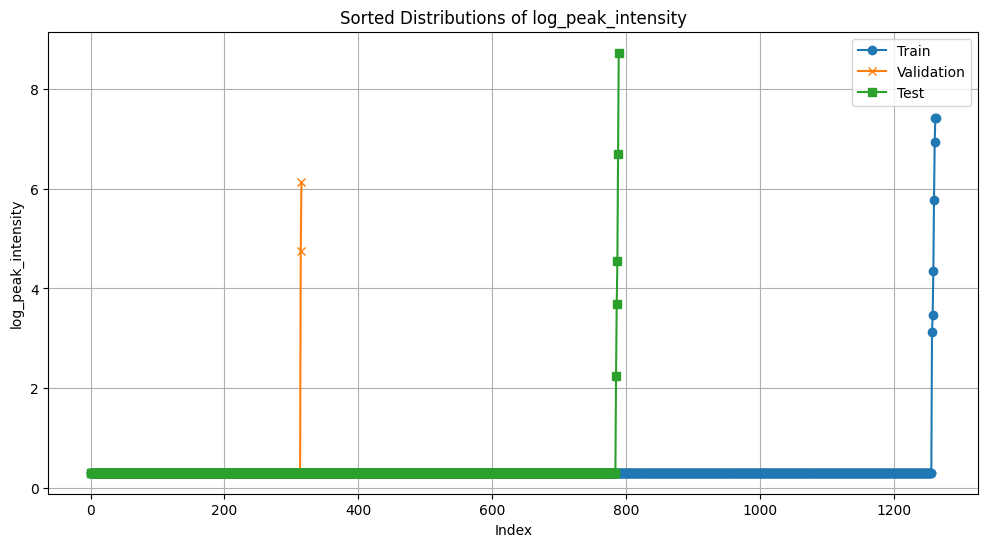

In [6]:
plot_sorted_distributions(train_y, val_y, test_y, title='Sorted Distributions of log_peak_intensity')

In [7]:
def shuffle_sets(train_x, train_y, val_x, val_y, test_x, test_y):
    """
    Shuffle the data within each of the training, validation, and test sets.
    
    :param:
    - train_x, train_y: Numpy arrays containing the training features and labels
    - val_x, val_y: Numpy arrays containing the validation features and labels
    - test_x, test_y: Numpy arrays containing the test features and labels
    
    :return:
    - Shuffled versions of train_x, train_y, val_x, val_y, test_x, test_y
    """
    train_x, train_y = shuffle(train_x, train_y)
    val_x, val_y = shuffle(val_x, val_y)
    test_x, test_y = shuffle(test_x, test_y)
    
    return train_x, train_y, val_x, val_y, test_x, test_y

# Shuffle the datasets
shuffled_train_x, shuffled_train_y, shuffled_val_x, shuffled_val_y, shuffled_test_x, shuffled_test_y = shuffle_sets(train_x, train_y, val_x, val_y, test_x, test_y)


In [8]:
from models import modeling
from sklearn.manifold import TSNE

In [9]:
mb = modeling.ModelBuilder()

# create my feature extractor
feature_extractor = mb.create_model_feat(inputs=19, feat_dim=9, hiddens=[18])

In [10]:
# print model summary
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense (Dense)               (None, 18)                360       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 18)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 171       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 9)                 0         
                                                                 
 normalize_layer (NormalizeL  (None, 9)                0         
 ayer)                                                           
                                                             

In [11]:
# plot model
mb.plot_model(feature_extractor)

In [12]:
def plot_tsne(model, X, y):
    """
    Applies t-SNE to the features extracted by the given model and plots them in 2D.
    The color of the points is determined by their label values.
    
    Parameters:
    - model: Trained feature extractor model
    - X: Input data
    - y: Target labels
    
    Returns:
    - A 2D t-SNE plot
    """
    # Extract features using the trained model
    features = model.predict(X)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(features)
    
    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y, cmap='viridis', alpha=0.6)

    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Label Value')

    plt.title('2D t-SNE Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    plt.show()

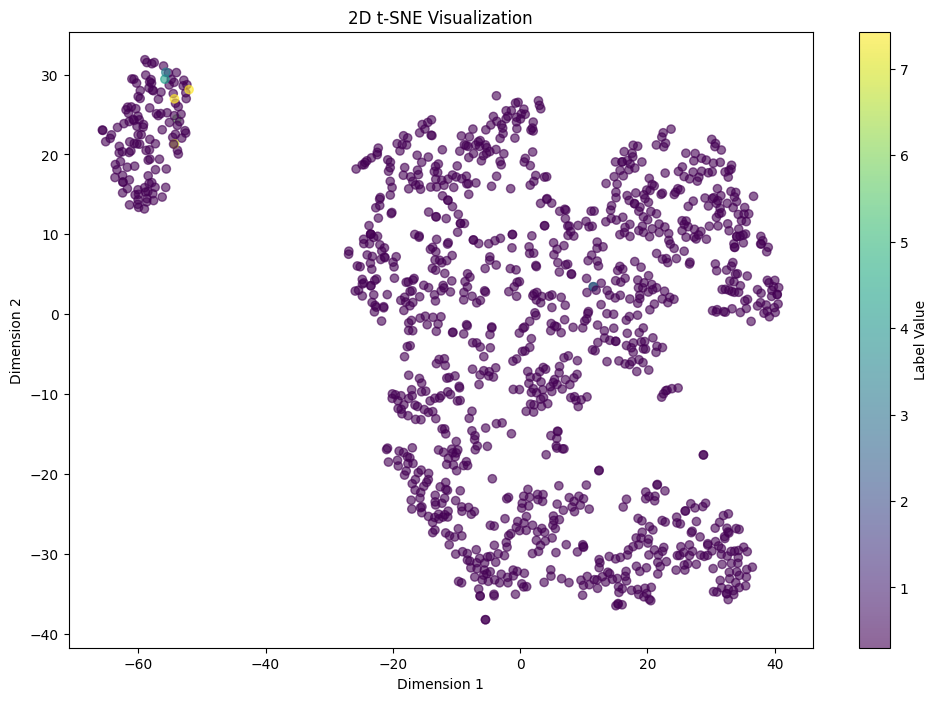

In [13]:
plot_tsne(feature_extractor, shuffled_train_x, shuffled_train_y)

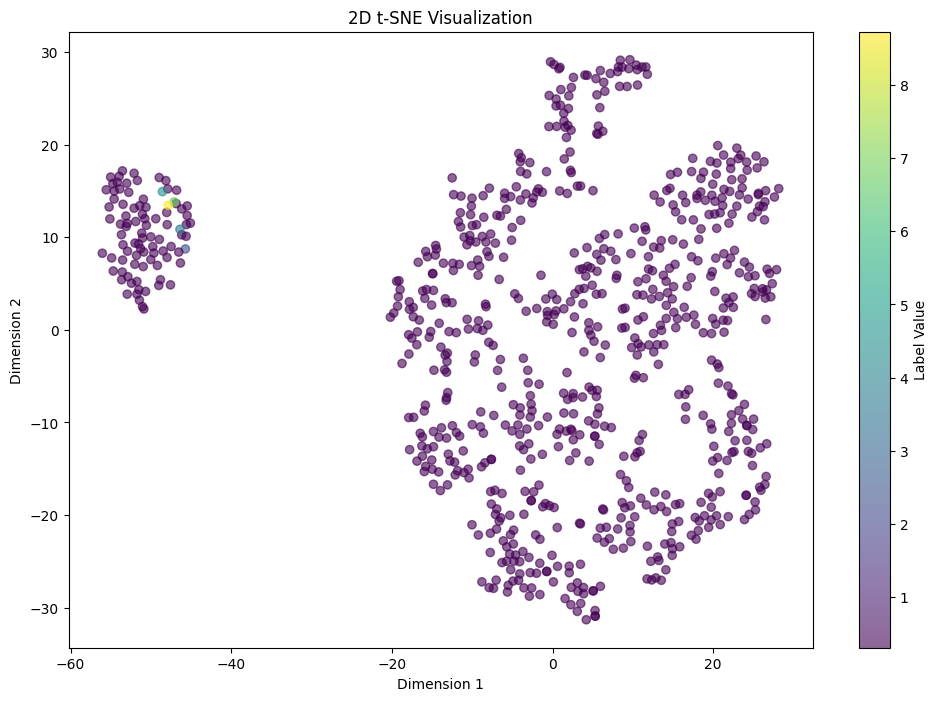

In [14]:
plot_tsne(feature_extractor, shuffled_test_x, shuffled_test_y)

In [16]:
import  random
def find_optimized_random_batch_size(y, num_to_catch=3, threshold=np.log(10), num_trials=1000, early_exit_ratio=0.95):
    """
    Optimized function to find the minimum batch size such that, when sampled at random,
    each batch is likely to contain at least 2 rows with target values greater than a given threshold.
    
    Parameters:
    - y: Numpy array containing the target values
    - threshold: The target threshold, default is ln(10)
    - num_trials: Number of trials to perform for each batch size
    - early_exit_ratio: The success ratio to achieve before stopping the trials for a given batch size
    
    Returns:
    - Minimum batch size that fulfills the condition
    """
    # Count the number of elements greater than the threshold
    count_above_threshold = np.sum(y > threshold)
    
    # If there are fewer than 2 elements above the threshold, return a message
    if count_above_threshold < num_to_catch:
        raise ValueError("There are not enough samples with target values greater than the threshold.")
    
    # Loop through possible batch sizes, starting from 2
    for batch_size in range(num_to_catch, len(y) + 1):
        success_count = 0
        
        for trial in range(num_trials):
            # Sample a random batch
            random_batch = random.sample(list(y), batch_size)
            
            # Check if the batch contains at least 2 elements greater than the threshold
            if np.sum(np.array(random_batch) > threshold) >= num_to_catch:
                success_count += 1
            
            # Early exit if success ratio is achieved
            if trial >= 500 and success_count / (trial + 1) >= early_exit_ratio:
                return batch_size

# Find the minimum batch size for the training set that satisfies the condition, using the optimized function
min_optimized_random_batch_size = find_optimized_random_batch_size(train_y, num_to_catch=3, num_trials=10000, early_exit_ratio=0.99)

min_optimized_random_batch_size


927

Run the command line:
 tensorboard --logdir logs/fit
Epoch 1/200
158/158 [==============================] - 9s 44ms/step - loss: 5.2884 - val_loss: 16.8052
Epoch 2/200
158/158 [==============================] - 6s 40ms/step - loss: 5.1317 - val_loss: 16.2020
Epoch 3/200
158/158 [==============================] - 6s 41ms/step - loss: 4.8469 - val_loss: 15.7904
Epoch 4/200
158/158 [==============================] - 7s 42ms/step - loss: 4.7112 - val_loss: 15.5498
Epoch 5/200
158/158 [==============================] - 6s 41ms/step - loss: 4.5831 - val_loss: 15.5319
Epoch 6/200
158/158 [==============================] - 7s 42ms/step - loss: 4.3751 - val_loss: 15.5773
Epoch 7/200
158/158 [==============================] - 7s 45ms/step - loss: 4.4951 - val_loss: 15.3167
Epoch 8/200
158/158 [==============================] - 6s 40ms/step - loss: 4.4511 - val_loss: 15.3579
Epoch 9/200
158/158 [==============================] - 7s 42ms/step - loss: 4.4456 - val_loss: 15.2816
Epoch 10/200
158/158

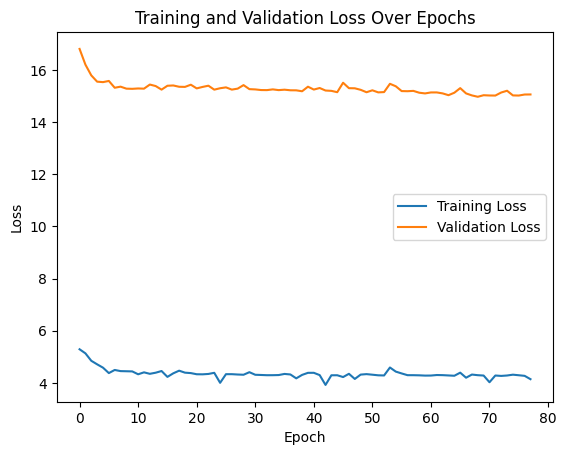

Epoch 1/69
198/198 [==============================] - 11s 47ms/step - loss: 6.5412
Epoch 2/69
198/198 [==============================] - 9s 45ms/step - loss: 6.4125
Epoch 3/69
198/198 [==============================] - 9s 46ms/step - loss: 6.4916
Epoch 4/69
198/198 [==============================] - 9s 47ms/step - loss: 6.1540
Epoch 5/69
198/198 [==============================] - 9s 46ms/step - loss: 6.5886
Epoch 6/69
198/198 [==============================] - 9s 46ms/step - loss: 6.4394
Epoch 7/69
198/198 [==============================] - 9s 46ms/step - loss: 6.4188
Epoch 8/69
198/198 [==============================] - 9s 45ms/step - loss: 6.4112
Epoch 9/69
198/198 [==============================] - 9s 45ms/step - loss: 6.4105
Epoch 10/69
198/198 [==============================] - 9s 46ms/step - loss: 6.2112
Epoch 11/69
198/198 [==============================] - 9s 45ms/step - loss: 6.3095
Epoch 12/69
198/198 [==============================] - 9s 45ms/step - loss: 6.4005
Epoch 13/69


In [13]:
mb.train_features(feature_extractor, shuffled_train_x, shuffled_train_y, shuffled_val_x, shuffled_val_y, epochs=200, batch_size=8)

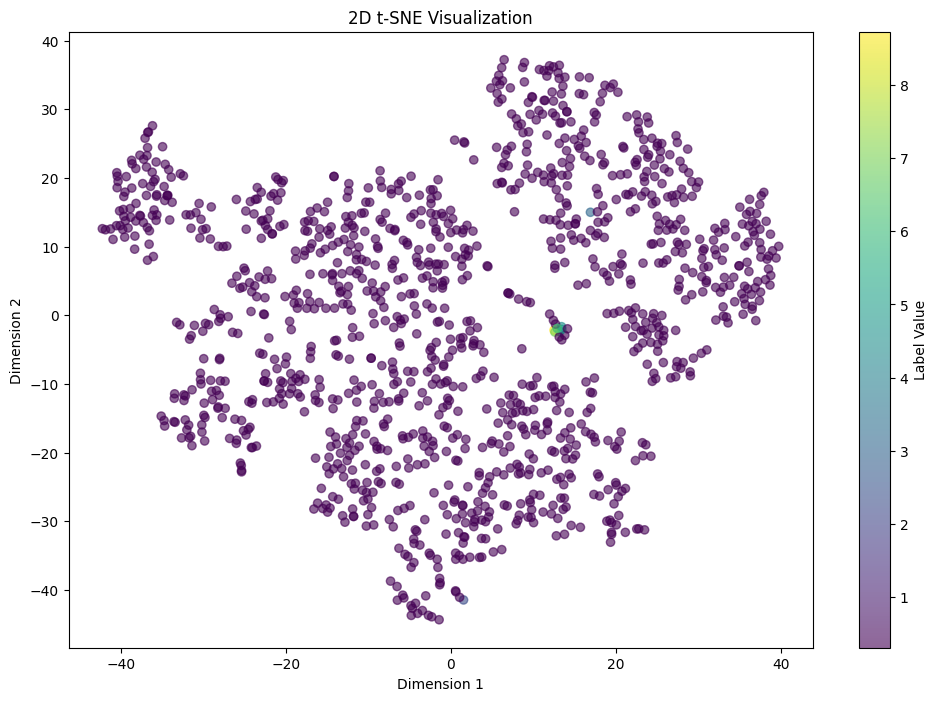

In [14]:
plot_tsne(feature_extractor, shuffled_train_x, shuffled_train_y)

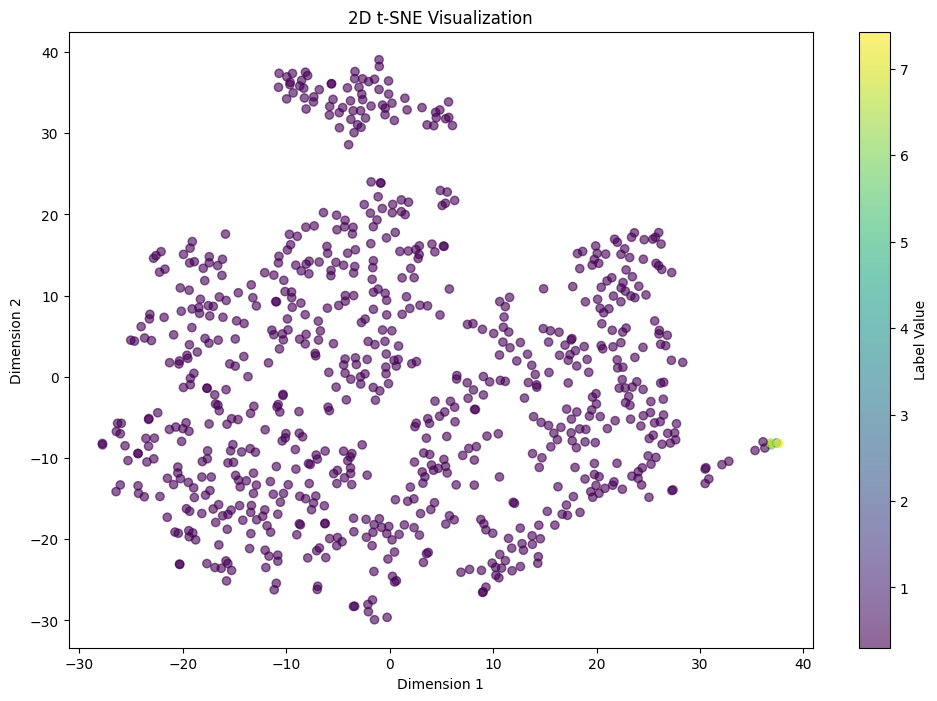

In [15]:
plot_tsne(feature_extractor, shuffled_test_x, shuffled_test_y)

# test 

In [25]:
res = next(mb.custom_data_generator(shuffled_train_x, shuffled_train_y, 8)) # works but always at the end
print(res)

(array([[0.24173065, 0.29508197, 0.24789644, 0.2068133 , 0.        ,
        0.196     , 0.6       , 0.73888889, 0.73333333, 0.57286432,
        0.3908046 , 0.37078652, 0.25081433, 0.74166667, 0.        ,
        0.99709256, 0.84019664, 0.        , 0.        ],
       [0.04381429, 0.05163934, 0.12330097, 0.10139485, 0.        ,
        0.1664    , 0.3625    , 0.81666667, 0.675     , 0.09045226,
        0.22988506, 0.35393258, 0.25880004, 0.64444444, 0.33333333,
        0.98229448, 0.21194244, 0.        , 0.        ],
       [0.66914914, 0.89754098, 0.66472492, 0.53299356, 0.        ,
        0.        , 0.3125    , 0.61944444, 0.79444444, 0.48241206,
        0.63218391, 0.63483146, 0.30019964, 1.        , 0.        ,
        0.99944864, 0.99938608, 0.88181017, 1.        ],
       [0.26104483, 0.50327869, 0.19352751, 0.11883047, 0.        ,
        0.4228    , 0.45      , 0.375     , 0.25      , 0.40703518,
        0.06896552, 0.51123596, 0.20994011, 0.25      , 0.        ,
        0.75

In [15]:
mb.train_features_injection(feature_extractor, shuffled_train_x, shuffled_train_y, shuffled_val_x, shuffled_val_y, epochs=200, batch_size=8)

Run the command line:
 tensorboard --logdir logs/fit
Epoch 1/200
 75/158 [=============>................] - ETA: 3s - loss: 216.5374

KeyboardInterrupt: 

In [ ]:
extended_model = mb.add_regression_head_with_proj(feature_extractor)
# fine-tuning
# TODO: update the train regression funtion
# TODO: apply the dense weights preprocessing to SEPs dataaset
history = mb.train_regression(
    extended_model, 
    shuffled_train_x, 
    shuffled_train_y, 
    shuffled_val_x, 
    shuffled_val_y, 
    loader.reweights, 
    loader.val_reweights,
    learning_rate=1e-4,
    epochs=400, batch_size=16)